In [1]:
import requests
import re
import json
from urllib.parse import urljoin
from bs4 import BeautifulSoup
import _thread
import time
import jieba
import jieba.analyse
from collections import Counter
from wordcloud import WordCloud
import pandas as pd
import matplotlib.pyplot as plt
from queue import Queue
import threading

PTT_URL = 'https://www.ptt.cc/bbs/HatePolitics/index.html'

In [2]:
def multi(urls):
    q_data = Queue()
    q_push = Queue()

    threads = []
    for url in urls:
        t = threading.Thread(target=crawl_article, args=(url, q_data, q_push))
        t.start()
        threads.append(t)

    for t in threads:
        t.join()

    data = []
    push = []

    for i in range(len(threads)):
        data.append((q_data.get()))
        push.extend((q_push.get()))

    return data, push

In [3]:
def crawl_comment_urls(amount=50):
    all_data = []
    comments = []
    nextPage = PTT_URL
    urls = []

    while len(urls) <= amount:
        # 對文章列表送出請求並取得列表主體
        resp = requests.get(nextPage, cookies={'over18': '1'})
        resp.encoding = 'utf-8'

        soup = BeautifulSoup(resp.text, 'html5lib')
        main_list = soup.find('div', class_='bbs-screen')

        nextPage = soup.find('div', 'btn-group btn-group-paging').find_all('a')[1]['href']
        nextPage = 'https://www.ptt.cc' + nextPage

        # 依序檢查文章列表中的 tag, 遇到分隔線就結束, 忽略這之後的文章
        for div in main_list.findChildren('div', recursive=False):

            class_name = div.attrs['class']

            # 遇到分隔線要處理的情況
            if class_name and 'r-list-sep' in class_name:
                print('Reach the last article of this page')
                break
            # 遇到目標文章
            if class_name and 'r-ent' in class_name:
                div_title = div.find('div', class_='title')
                a_title = div_title.find('a', href=True)

                # 如果文章已經被刪除，就跳過
                if not a_title:
                    continue

                article_URL = urljoin(PTT_URL, a_title['href'])
                article_title = a_title.text
                urls.append(article_URL)
                print('Parse {} - {}'.format(article_title, article_URL))

                if len(urls) > amount:
                    print(f'Stop crawling due to reaching the amount. Amount: {len(urls)}')
                    return urls

                # 呼叫上面寫好的 function 來對文章進行爬蟲
                #parse_data, parse_comment = crawl_article(article_URL)
                # parse_data = _thread.start_new_thread(crawl_article, (article_URL, ))

                # 將爬完的資料儲存
                #all_data.append(parse_data)
                #comments.extend(parse_comment)

    return urls

In [4]:
def crawl_article(url, q_data, q_push):
    response = requests.get(url, cookies={'over18': '1'})
    response.encoding = 'utf-8'

    # 假設網頁回應不是 200 OK 的話, 我們視為傳送請求失敗
    if response.status_code != 200:
        print('Error - {} is not available to access'.format(url))
        return

    # 將網頁回應的 HTML 傳入 BeautifulSoup 解析器, 方便我們根據標籤 (tag) 資訊去過濾尋找
    soup = BeautifulSoup(response.text, 'html5lib')

    # 取得文章內容主體
    main_content = soup.find(id='main-content')

    # 假如文章有屬性資料 (meta), 我們在從屬性的區塊中爬出作者 (author), 文章標題 (title), 發文日期 (date)
    metas = main_content.select('div.article-metaline')
    author = ''
    title = ''
    date = ''
    author_id = ''
    author_name = ''
    if metas:
        if metas[0].select('span.article-meta-value')[0]:
            author = metas[0].select('span.article-meta-value')[0].string
            author_separate = author.split(' ')
            author_id = author_separate[0].strip()

            if len(author_separate) > 1:
                author_name = author_separate[1].strip()[1:-1]

        if metas[1].select('span.article-meta-value')[0]:
            title = metas[1].select('span.article-meta-value')[0].string
        if metas[2].select('span.article-meta-value')[0]:
            date = metas[2].select('span.article-meta-value')[0].string

        # 從 main_content 中移除 meta 資訊（author, title, date 與其他看板資訊）
        #
        # .extract() 方法可以參考官方文件
        #  - https://www.crummy.com/software/BeautifulSoup/bs4/doc/#extract
        for m in metas:
            m.extract()
        for m in main_content.select('div.article-metaline-right'):
            m.extract()

    # 取得留言區主體
    pushes = main_content.find_all('div', class_='push')
    for p in pushes:
        p.extract()

    # 假如文章中有包含「※ 發信站: 批踢踢實業坊(ptt.cc), 來自: xxx.xxx.xxx.xxx」的樣式
    # 透過 regular expression 取得 IP
    # 因為字串中包含特殊符號跟中文, 這邊建議使用 unicode 的型式 u'...'
    try:
        ip = main_content.find(text=re.compile(u'※ 發信站:'))
        ip = re.search('[0-9]*\.[0-9]*\.[0-9]*\.[0-9]*', ip).group()
    except Exception as e:
        ip = ''

    # 移除文章主體中 '※ 發信站:', '◆ From:', 空行及多餘空白 (※ = u'\u203b', ◆ = u'\u25c6')
    # 保留英數字, 中文及中文標點, 網址, 部分特殊符號
    #
    # 透過 .stripped_strings 的方式可以快速移除多餘空白並取出文字, 可參考官方文件
    #  - https://www.crummy.com/software/BeautifulSoup/bs4/doc/#strings-and-stripped-strings
    filtered = []
    for v in main_content.stripped_strings:
        # 假如字串開頭不是特殊符號或是以 '--' 開頭的, 我們都保留其文字
        if v[0] not in [u'※', u'◆'] and v[:2] not in [u'--']:
            filtered.append(v)

    # 定義一些特殊符號與全形符號的過濾器
    expr = re.compile(u'[^一-龥。；，：“”（）、？《》\s\w:/-_.?~%()]')
    for i in range(len(filtered)):
        filtered[i] = re.sub(expr, '', filtered[i])

    # 移除空白字串, 組合過濾後的文字即為文章本文 (content)
    filtered = [i for i in filtered if i]
    content = ' '.join(filtered)

    # 處理留言區
    # p 計算推文數量
    # b 計算噓文數量
    # n 計算箭頭數量
    p, b, n = 0, 0, 0
    messages = []
    for push in pushes:
        # 假如留言段落沒有 push-tag 就跳過
        if not push.find('span', 'push-tag'):
            continue

        # 過濾額外空白與換行符號
        # push_tag 判斷是推文, 箭頭還是噓文
        # push_userid 判斷留言的人是誰
        # push_content 判斷留言內容
        # push_ipdatetime 判斷留言日期時間
        push_tag = push.find('span', 'push-tag').string.strip(' \t\n\r')
        push_userid = push.find('span', 'push-userid').string.strip(' \t\n\r')
        push_content = push.find('span', 'push-content').strings
        push_content = ' '.join(push_content)[1:].strip(' \t\n\r')
        push_ipdatetime = push.find('span', 'push-ipdatetime').string.strip(' \t\n\r')

        # 整理打包留言的資訊, 並統計推噓文數量
        messages.append({
            'push_tag': push_tag,
            'push_userid': push_userid,
            'push_content': push_content,
            'push_ipdatetime': push_ipdatetime,
            'push_ipdate': push_ipdatetime.split(' ')[0].strip()
        })

        # comments.append(messages)
        if push_tag == u'推':
            p += 1
        elif push_tag == u'噓':
            b += 1
        else:
            n += 1

    # 統計推噓文
    # count 為推噓文相抵看這篇文章推文還是噓文比較多
    # all 為總共留言數量
    message_count = {'all': p + b + n, 'count': p - b, 'push': p, 'boo': b, 'neutral': n}

    # 整理文章資訊

    data = {
        'url': url,
        # 'article_author': author,
        'article_author_id': author_id,
        'article_author_name': author_name,
        'article_title': title,
        'article_date': date,
        'article_content': content,
        'ip': ip,
        'message_count': message_count
        #'messages': messages
    }

    q_data.put(data)
    q_push.put(messages)

In [5]:
def save_data(data):
    # 將爬完的資訊存成 json 檔案
    with open('parse_data.json', 'w+', encoding='utf-8') as f:
        json.dump(data, f, ensure_ascii=False, indent=4)

def load_data(path):
    # 讀取之前存成 json 檔案的資訊
    with open(path, 'r', encoding='utf-8') as reader:
        data = json.load(reader)

    return data

In [6]:
def getStopWord():
    # 讀取檔案取得stopwords，讓jieba分析更有價值
    stopWords = list()
    with open('cn_stopwords.txt', 'r', encoding='utf-8') as reader:
        rows = reader.readlines()
        for row in rows:
            if len(row.strip()) > 0:
                stopWords.append(row.strip())
    return stopWords

In [7]:
def jiebaWord(content, topk=20):
    #斷詞並且統計每個詞彙出現的頻率
    
    regStr = '\s+|[0-9a-zA-Z_\{\}\(\)（）\./:~\=]+'
    regex = re.compile(regStr)
    
    jieba.set_dictionary('dict.txt.big') # 使用繁體辭庫
    jieba.load_userdict('user_dict.txt')  #自定義詞彙  
    jieba.analyse.set_stop_words('cn_stopwords.txt')
    
    stopWords = getStopWord()
    
    words = jieba.cut(content, cut_all=False)
    
    filterWords_list = [ w for w in words if w not in stopWords and not regex.match(w)]
    filterWords_str = ''.join(filterWords_list)
    
    tags = jieba.analyse.extract_tags(filterWords_str, topk)
        
    count = []
    for t in tags:
        count.append(filterWords_list.count(t))
    tagspd = pd.DataFrame([tags, count]).T
    tagspd = tagspd.rename({0:'KeyWords', 1:'Times'}, axis='columns')
    return tagspd, tags
    
def jiebaCount(data, columnName, topK = 20):
    #透過此function過濾資料，使用jiebaWord斷詞
    all_content = ''
    
    for d in data:
        all_content += d[columnName]
    
    content_pd, content_tags = jiebaWord(all_content, topK)

    return content_pd, content_tags

In [8]:
def wordcloudPTT(tags):
    text = " ".join(tags)
    font_path = 'msjh.ttc'
    #font_path = 'hi.ttf'
    wordcloud = WordCloud(width=1200, height=600, max_font_size=200, max_words=200, 
                          background_color='black', font_path=font_path, colormap='Dark2').generate(text)
    plt.figure(dpi=600)
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()

In [9]:
def CollectIPInfo(inputData, author_ip, author_id, times):
    #觀察每個IP有多少人使用來發文/推文
    
    ipList = list()
    
    for ip in inputData[author_ip]:
        if not ip in ipList:
            ipList.append(ip)
    
    tempPd = pd.DataFrame(ipList)
    tempPd = tempPd.rename({0:author_ip}, axis='columns')
    
    user_id = []       # 裝每個發/推文者的id
    authorCount = []      # 裝每個ip的推/發文數或推/發文人數
    
    
    for ip in ipList:
        tempData = inputData[inputData[author_ip] == ip]
        tempList = list()
        
        #計算同一個ip，總共有幾個人使用，同id只算一次
        for identification in tempData[author_id]:
            if identification not in tempList:
                tempList.append(identification)
            
        user_id.append(';'.join(tempList))
        authorCount.append(len(tempList))
    
    tempPd[author_id] = user_id
    tempPd[times] = authorCount
    tempPd = tempPd.sort_values(by=times, ascending=False).reset_index()
    
    return tempPd

In [10]:
def CollectUserInfo(inputData, author, content, times):
    #觀察每個id發了多少文章/推了多少文章
    
    authorList = list()
    
    for person in inputData[author]:
        if not person in authorList:
            authorList.append(person)
    
    tempPd = pd.DataFrame(authorList)
    tempPd = tempPd.rename({0:author}, axis='columns')
    
    allArticles = ''
    count = 0
    user_id = []       # 裝每個發/推文者的id
    articleCount = []      # 裝每個id的推/發文數或推/發文人數
    
    
    for person in authorList:
        tempData = inputData[inputData[author] == person]
        
        # 取得同author的所有文章內容，並且計算總共發了幾篇文章
        for info in tempData[content]:
            allArticles += info + ' '
            
            if len(user_id) > count:
                user_id[count] = user_id[count] + ';' + info
            else:
                user_id.append(info)
            
        articleCount.append(len(tempData[content]))
        count += 1
    
    tempPd[content] = user_id
    tempPd[times] = articleCount
    tempPd = tempPd.sort_values(by=times, ascending=False).reset_index()
    
    return tempPd


In [11]:
import time

start = time.time()
urls = crawl_comment_urls(500)
data, comments = multi(urls)
save_data(data)
print('time difference:', time.time() - start, 'seconds')

Parse [討論] 柯文哲高雄人氣高，跟陳菊有關？？ - https://www.ptt.cc/bbs/HatePolitics/M.1593999880.A.AFD.html
Parse Re: [討論] 柯文哲在高雄人氣到底如何 ? - https://www.ptt.cc/bbs/HatePolitics/M.1594000340.A.CEA.html
Parse Re: [討論] 現在是民進黨執政為什麼還要放大檢視在野 - https://www.ptt.cc/bbs/HatePolitics/M.1594000438.A.4B4.html
Parse Re: [討論] 支持「中醫」改名 「台醫」或「漢醫」 - https://www.ptt.cc/bbs/HatePolitics/M.1594000827.A.D1F.html
Parse Re: [討論] 支持「中醫」改名 「台醫」或「漢醫」 - https://www.ptt.cc/bbs/HatePolitics/M.1594001006.A.AF8.html
Parse [討論] 陪審團要依法審判嗎？ - https://www.ptt.cc/bbs/HatePolitics/M.1594001198.A.070.html
Parse [討論] 論文仔不是也說小池百合子學歷造假？ - https://www.ptt.cc/bbs/HatePolitics/M.1594001231.A.725.html
Parse [討論] 1千萬買不起台北房？日人曝「合理價格」 - https://www.ptt.cc/bbs/HatePolitics/M.1594001409.A.BCE.html
Parse [討論] 吳益政在議長補選會選誰？ - https://www.ptt.cc/bbs/HatePolitics/M.1594001653.A.E19.html
Parse [討論] 洞庭湖沒幫忙扛洪水嗎 - https://www.ptt.cc/bbs/HatePolitics/M.1594002431.A.437.html
Parse [討論] 小黨的生存之道 - https://www.ptt.cc/bbs/HatePolitics/M.1594002763.A.6A3.html
Reach the 

Parse [黑特] 香港梁凱晴:一國一制?回大陸啦!!! - https://www.ptt.cc/bbs/HatePolitics/M.1593951745.A.DAA.html
Parse Re: [討論] 為什麼2018韓國瑜沒打陳其邁高捷泰勞案 - https://www.ptt.cc/bbs/HatePolitics/M.1593952406.A.EE6.html
Parse [討論] 國民黨支持者憑什麼出來投票 - https://www.ptt.cc/bbs/HatePolitics/M.1593952612.A.53A.html
Parse [討論] 感謝蔡英文政府 - https://www.ptt.cc/bbs/HatePolitics/M.1593953050.A.073.html
Parse Re: [轉錄] 李兆立-失控的高房價 被綁架的台灣經濟 - https://www.ptt.cc/bbs/HatePolitics/M.1593953330.A.8F2.html
Parse Re: [討論] 民眾黨打泰勞暴動事件 - https://www.ptt.cc/bbs/HatePolitics/M.1593953334.A.427.html
Parse [新聞] 中國施壓索馬利蘭》拿設外館交換斷絕與台灣往來　索馬利亞批 - https://www.ptt.cc/bbs/HatePolitics/M.1593953783.A.74B.html
Parse [討論] 葉元之批:陳時中噁心甩鍋 - https://www.ptt.cc/bbs/HatePolitics/M.1593953802.A.423.html
Parse [新聞] 傳英國擬發消費券拚經濟 大人1萬8小孩90 - https://www.ptt.cc/bbs/HatePolitics/M.1593953997.A.D4C.html
Parse [轉錄] 台灣民眾黨：崁頂需要改變。 - https://www.ptt.cc/bbs/HatePolitics/M.1593954339.A.18F.html
Parse [討論] 現在是民進黨執政為什麼還要放大檢視在野 - https://www.ptt.cc/bbs/HatePolitics/M.1593954572.A.6CF

Parse Re: [討論] TMD 選舉其實很髒對吧 - https://www.ptt.cc/bbs/HatePolitics/M.1593931161.A.F8C.html
Parse Re: [新聞] 酸陳其邁裝年輕 李眉蓁：我都可以叫他叔 - https://www.ptt.cc/bbs/HatePolitics/M.1593931374.A.405.html
Parse Re: [黑特] 賴品妤掉進冷泉裡 - https://www.ptt.cc/bbs/HatePolitics/M.1593931763.A.476.html
Parse Re: [黑特] 民進黨粉討厭時代力量的重點原因是啥 - https://www.ptt.cc/bbs/HatePolitics/M.1593931921.A.24D.html
Parse [新聞] 擊鼓進軍！ 蘇貞昌推振興：讓台灣成亂世中福地 - https://www.ptt.cc/bbs/HatePolitics/M.1593932924.A.2A6.html
Parse Re: [討論] 爆雷王賴品妤這個整理時間點不錯 - https://www.ptt.cc/bbs/HatePolitics/M.1593933098.A.408.html
Parse Re: [討論] 楊寶禎藍白可以合作 陳揮文千萬別上當  - https://www.ptt.cc/bbs/HatePolitics/M.1593933145.A.D8A.html
Parse [討論] 全台只剩高雄還在選舉 - https://www.ptt.cc/bbs/HatePolitics/M.1593933751.A.BFA.html
Parse Re: [新聞] 中醫也要「去中化」 游錫堃：可改叫台醫 - https://www.ptt.cc/bbs/HatePolitics/M.1593933822.A.C1E.html
Parse Re: [討論] 真的有所謂的豬哥票婆媽票？ - https://www.ptt.cc/bbs/HatePolitics/M.1593933916.A.3FF.html
Parse [討論] 民眾黨FB:開打陳其邁 - https://www.ptt.cc/bbs/HatePolitics/M.1593933990.

Parse Re: [討論] 楊寶禎藍白可以合作 陳揮文千萬別上當  - https://www.ptt.cc/bbs/HatePolitics/M.1593907144.A.2B3.html
Parse [討論] 政黨的優劣評比 - https://www.ptt.cc/bbs/HatePolitics/M.1593907947.A.E29.html
Parse Re: [討論] 真的有所謂的豬哥票婆媽票？ - https://www.ptt.cc/bbs/HatePolitics/M.1593908093.A.239.html
Parse [新聞] 連勝文：國民黨執政台灣領空沒有被侵犯過 - https://www.ptt.cc/bbs/HatePolitics/M.1593908542.A.661.html
Parse Re: [黑特] 民進黨粉討厭時代力量的重點原因是啥 - https://www.ptt.cc/bbs/HatePolitics/M.1593908549.A.CFC.html
Parse [討論] 殺警案診斷醫生沈正哲:理想女友是林依晨 - https://www.ptt.cc/bbs/HatePolitics/M.1593908941.A.9C8.html
Parse Re: [討論] 楊寶禎藍白可以合作 陳揮文千萬別上當  - https://www.ptt.cc/bbs/HatePolitics/M.1593908971.A.5EB.html
Parse Re: [討論] 柯文哲醜化陳菊這招快沒用了嗎？ - https://www.ptt.cc/bbs/HatePolitics/M.1593909282.A.F97.html
Parse Fw: [新聞] 菸害防制修法 衛福部傾向合法納管加熱菸 - https://www.ptt.cc/bbs/HatePolitics/M.1593911455.A.2BA.html
Parse [轉錄] 黃珊珊 FB - https://www.ptt.cc/bbs/HatePolitics/M.1593911466.A.249.html
Parse Re: [討論] 柯文哲醜化陳菊這招快沒用了嗎？ - https://www.ptt.cc/bbs/HatePolitics/M.1593911947.A

Parse [討論] 水利會韭菜長長就被綠共割了!!! - https://www.ptt.cc/bbs/HatePolitics/M.1593865523.A.E20.html
Parse Re: [討論] 時代力量支持者為什麼要當柯黑？ - https://www.ptt.cc/bbs/HatePolitics/M.1593865592.A.F75.html
Parse Re: [黑特] 民進黨粉討厭時代力量的重點原因是啥? - https://www.ptt.cc/bbs/HatePolitics/M.1593865696.A.6F9.html
Parse Re: [討論] 呱吉：目前剩XX黨還有在花錢養網軍 - https://www.ptt.cc/bbs/HatePolitics/M.1593866176.A.F52.html
Parse [討論] 數位支付3倍券就送2000圓? - https://www.ptt.cc/bbs/HatePolitics/M.1593866275.A.2B5.html
Parse [討論] 港版國安法已非「港人治港」！ - https://www.ptt.cc/bbs/HatePolitics/M.1593866760.A.55F.html
Parse [創作] 月初日環蝕+月中大月暈 本月大凶宜靜修 - https://www.ptt.cc/bbs/HatePolitics/M.1593866980.A.3E4.html
Parse [討論] 南部人：台北市長就是爛，怎麼反駁？ - https://www.ptt.cc/bbs/HatePolitics/M.1593866995.A.2C0.html
Parse [新聞] 國民黨籲北京：正視港人治港承諾 - https://www.ptt.cc/bbs/HatePolitics/M.1593867184.A.F40.html
Parse [討論] 罷免烽火連天 - https://www.ptt.cc/bbs/HatePolitics/M.1593867341.A.74A.html
Parse [討論] 他媽的日本你們好好防疫會死嗎.... - https://www.ptt.cc/bbs/HatePolitics/M.1593867413.A.96B.html
Pars

Parse [討論] 香港國安法通過，台股開啟慶祝行情 - https://www.ptt.cc/bbs/HatePolitics/M.1593839980.A.6B0.html
Parse [討論] 柯建銘之子吸毒 引發網友熱議 - https://www.ptt.cc/bbs/HatePolitics/M.1593839988.A.214.html
Parse [討論] 柯文哲的政治生命是否即將到了盡頭？ - https://www.ptt.cc/bbs/HatePolitics/M.1593840232.A.3ED.html
Parse [新聞] 政治上不可多得的奇葩！謝坤宏點名他戰20 - https://www.ptt.cc/bbs/HatePolitics/M.1593840332.A.97D.html
Parse [新聞] 革實院辦營隊 羅智強:年輕人沒放棄國民黨 - https://www.ptt.cc/bbs/HatePolitics/M.1593840400.A.AAA.html
Parse [新聞] 到香港會被抓？呂秋遠點出這10類台灣人 - https://www.ptt.cc/bbs/HatePolitics/M.1593840536.A.C76.html
Parse [討論] 張13到底什麼咖？離開黨就開始亂嗆人 - https://www.ptt.cc/bbs/HatePolitics/M.1593840616.A.E1E.html
Parse Re: [討論] 呱吉：目前剩XX黨還有在花錢養網軍 - https://www.ptt.cc/bbs/HatePolitics/M.1593840841.A.8BB.html
Parse [討論] 我還是領3倍卷了.... - https://www.ptt.cc/bbs/HatePolitics/M.1593840910.A.0BD.html
Stop crawling due to reaching the amount. Amount: 501
time difference: 25.57567310333252 seconds


In [12]:
content_pd, content_tags = jiebaCount(data, 'article_content', 40) #看看發文中，最常出現的詞彙
message_pd, message_tags = jiebaCount(comments, 'push_content', 40) #看看推文中，最常出現的詞彙

Building prefix dict from C:\Users\10904085\Desktop\cupoy\web\Final(PTT)\dict.txt.big ...
Dumping model to file cache C:\Users\10904085\AppData\Local\Temp\jieba.udfa9e734b7eb9a15dde63142dd63170e.cache
Loading model cost 1.255 seconds.
Prefix dict has been built successfully.
Building prefix dict from C:\Users\10904085\Desktop\cupoy\web\Final(PTT)\dict.txt.big ...
Loading model from cache C:\Users\10904085\AppData\Local\Temp\jieba.udfa9e734b7eb9a15dde63142dd63170e.cache
Loading model cost 1.117 seconds.
Prefix dict has been built successfully.


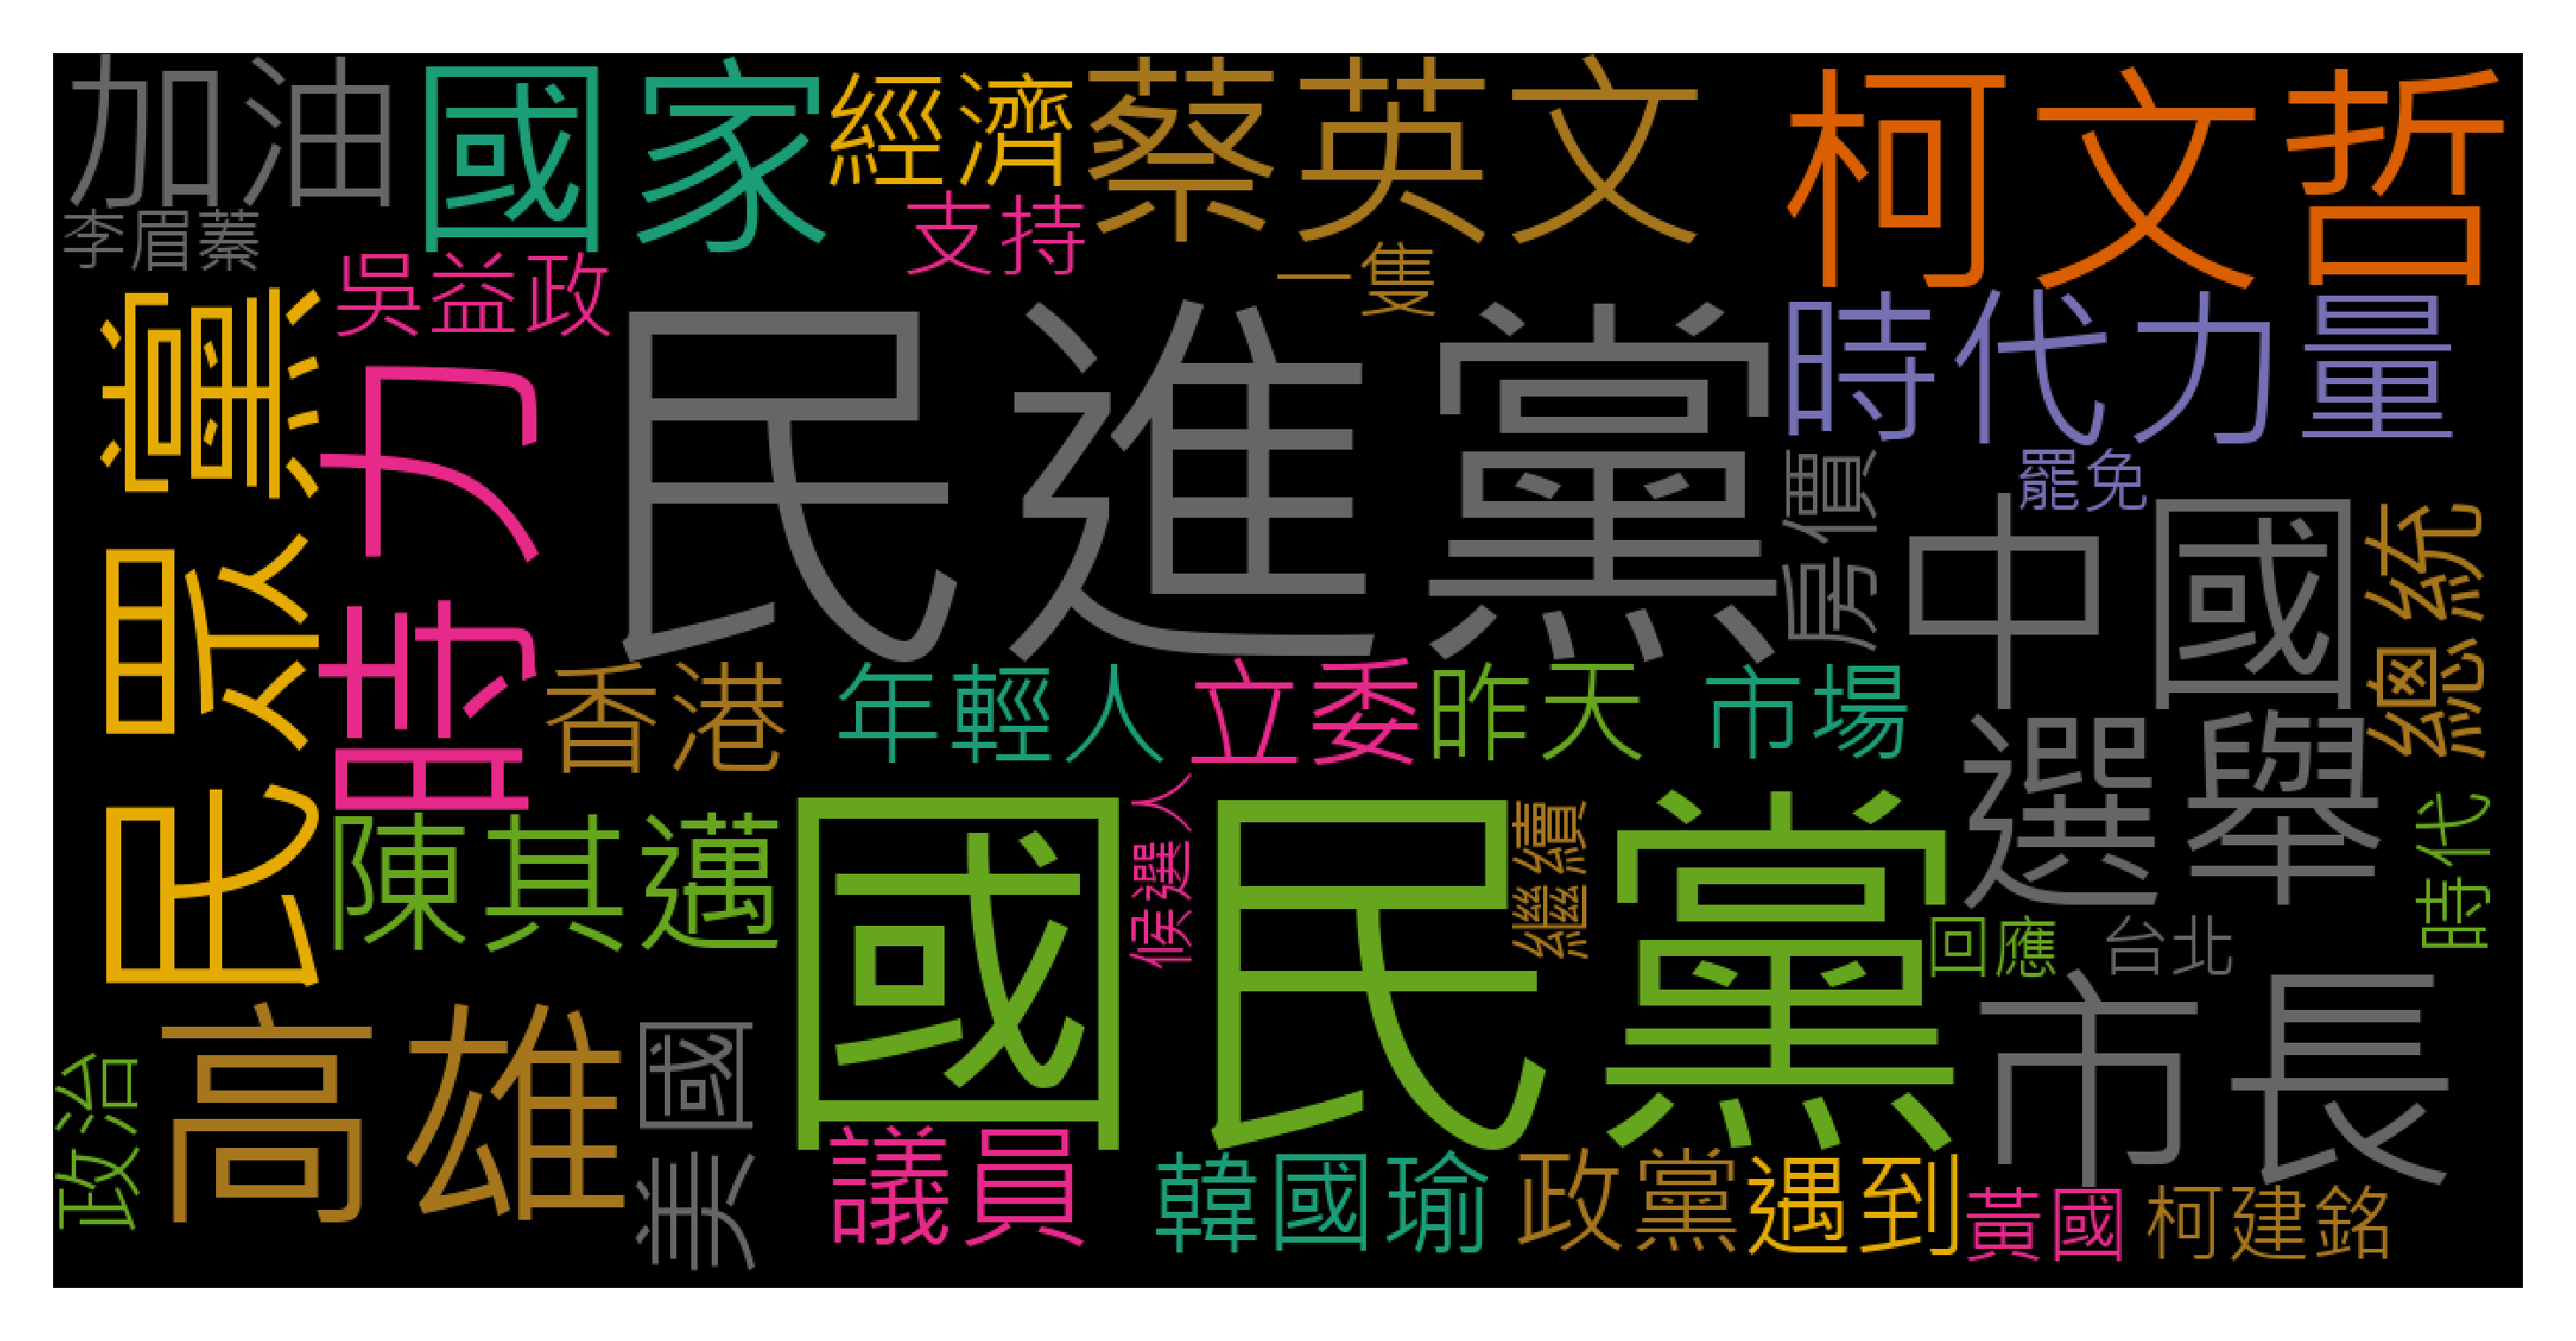

In [13]:
wordcloudPTT(content_tags) #發文的文字雲

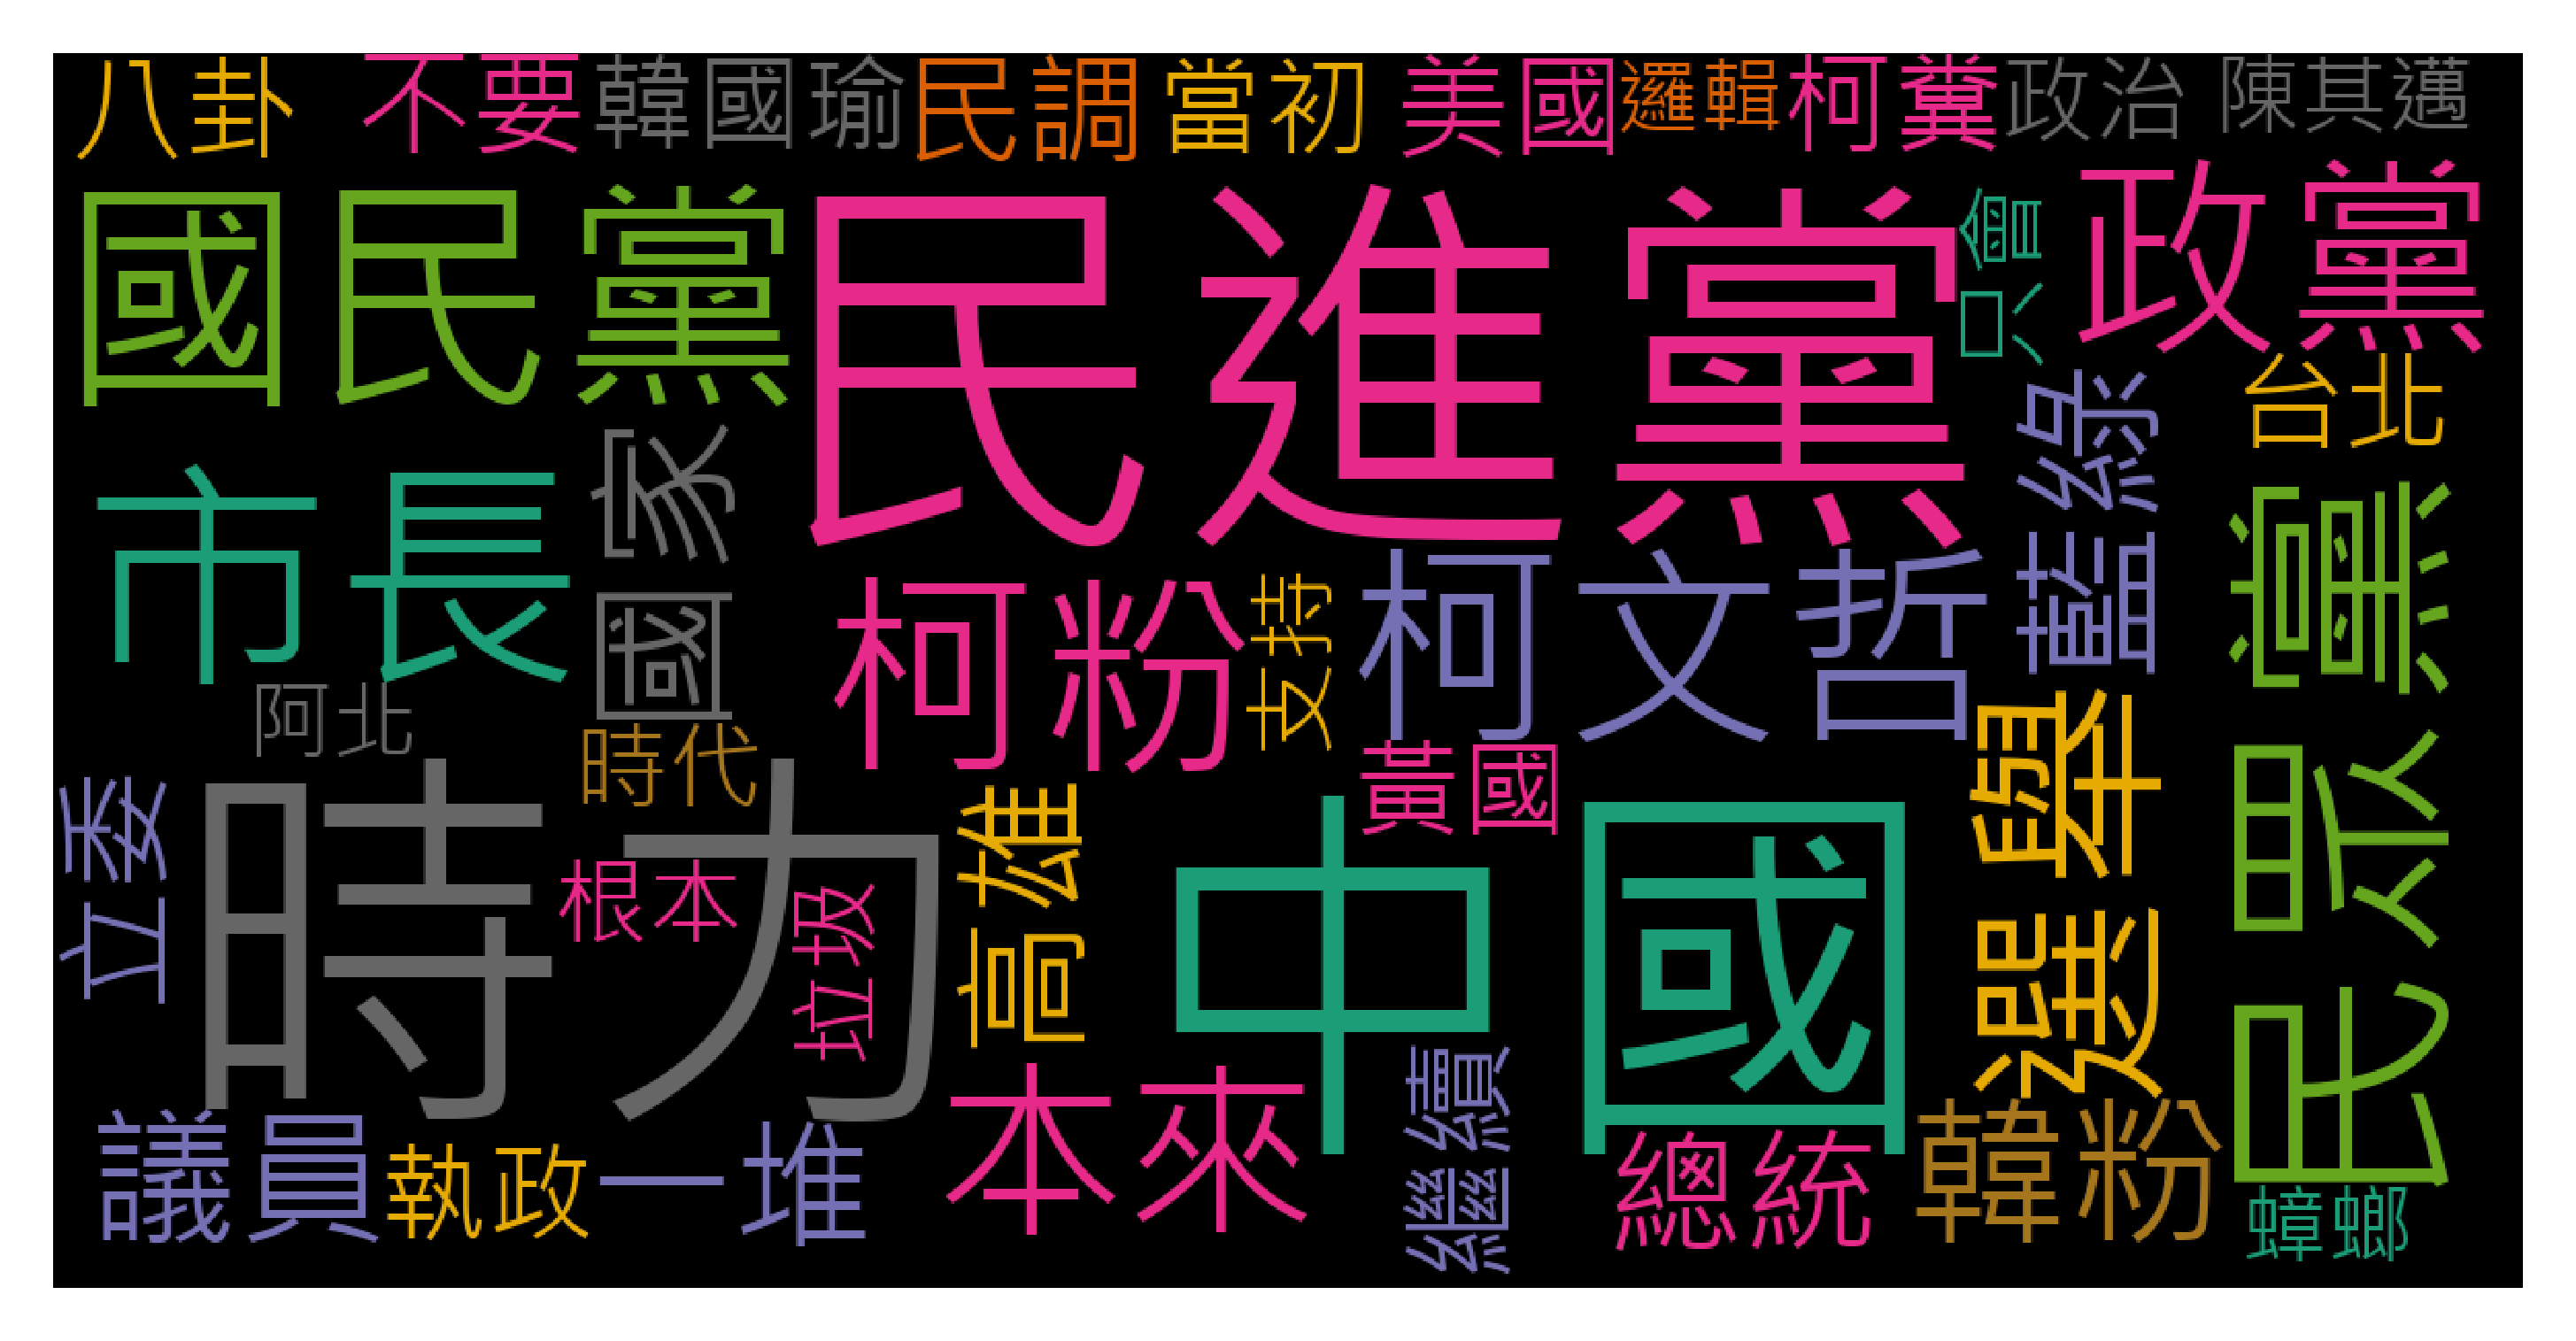

In [14]:
wordcloudPTT(message_tags) #推文的文字雲

In [15]:
content_pd.sort_values(by=['Times'], ascending = False) #發文最常出現的詞彙以及其頻率

,KeyWords,Times
0,民進黨,626
2,柯文哲,385
1,國民黨,385
3,中國,279
4,民眾黨,258
5,市長,254
18,香港,251
7,高雄,244
28,支持,223
29,政治,207


In [16]:
message_pd.sort_values(by=['Times'], ascending = False) #推文最常出現的詞彙以及其頻率

,KeyWords,Times
0,時力,411
1,民進黨,361
2,中國,283
22,不要,251
3,國民黨,249
4,民眾黨,238
5,市長,212
31,政治,209
33,支持,207
6,柯文哲,198


In [17]:
pddata = pd.DataFrame(data)
pdmessage = pd.DataFrame(comments)

In [18]:
pdIdArticle = CollectUserInfo(pddata, 'article_author_id', 'article_content', 'article_times')
pdIdPush = CollectUserInfo(pdmessage, 'push_userid', 'push_content', 'push_times')

In [19]:
pdIPAuthor = CollectIPInfo(pddata, 'ip', 'article_author_id', 'author_count')
pdIPTimePush = CollectIPInfo(pdmessage, 'push_ipdatetime', 'push_userid', 'push_userid_count')
pdIPDatePush = CollectIPInfo(pdmessage, 'push_ipdate', 'push_userid', 'push_userid_count')

In [20]:
pdIdArticle

,index,article_author_id,article_content,article_times
0,20,words2012,對性騷擾 受害者的保護 對加害者的懲罰\n\n我覺得我國做得很差\n\n\n對性騷的處理 感...,11
1,122,alexrow,在檢討 選戰策略前 我發現一個有趣時間序\n\n吳益政高雄市議員就任時間 2002/12/2...,9
2,79,CavendishJr,昨天香港區議員梁凱晴\n\n日常街站宣傳\n\n遇到穿曼聯衣服的藍絲鬧場\n\n凱晴昨天這樣...,8
3,34,TheoEpstein,: 噓 kichyo: 原原po：2018、19已經不滿2020卻投TPP? ...,8
4,12,macaron5566,綠共將要強推國民法官的制度，以後你各位犯罪被抓，\n都可能面臨陪審團或參審的人民的審判，所以...,8
...,...,...,...,...
234,125,stayinalive,: line pay money實際營運者是高雄的一卡通公司，只是把軟體寄生進line裡面 ...,1
235,127,GAYhivAIDS,完整標題：中國疾控中心：新型豬流感沒有即刻威脅\n發稿單位：中央社\n發稿時間：2020/0...,1
236,132,RIFF,昨天七月4日 遇到其中兩隻 請民進黨加油 昨天七月3日 遇到其中一隻 請民進黨加油 昨天...,1
237,133,KingChang711,: TMD標榜新政治 : 但選舉其實一直用骯髒的打法 : 像是立委補選陳思宇 : 或是三重針...,1


In [21]:
import time
time.time()

1594003059.2910519

In [22]:
start = time.time()

print(time.time()-start)

0.0
